In [ ]:
# import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1. Dataset Loading & Splitting
dataset_path = "Garbage Classification"

transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])

In [3]:
# Load full dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into train/val/test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [4]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['recycable', 'trash']


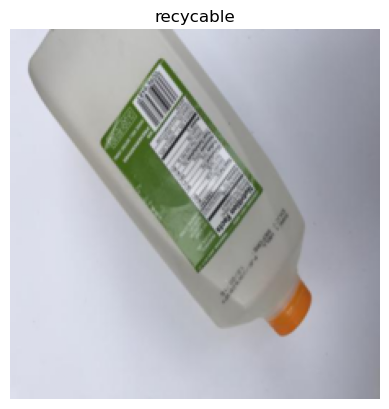

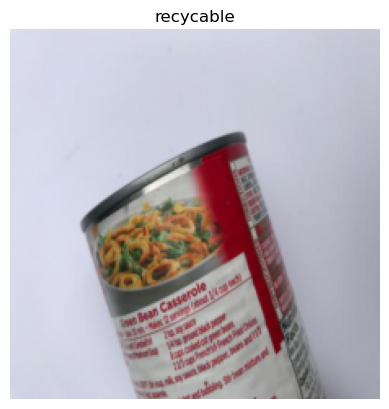

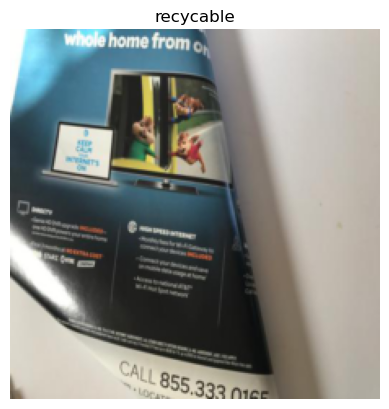

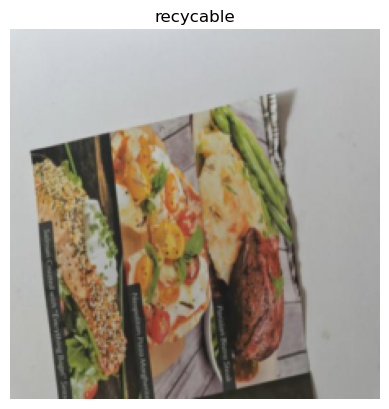

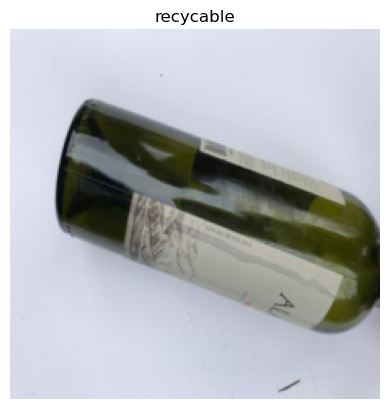

In [5]:
# Show sample images
def imshow(img, title):
    img = img.permute(1, 2, 0)  # CHW -> HWC
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

images, labels = next(iter(train_loader))
for i in range(5):  # Show 5 images
    imshow(images[i], title=class_names[labels[i]])

In [6]:
# 2. Training Function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    return acc

In [7]:
# 3. Case 1: Unfreeze last FC layer only
alexnet1 = models.alexnet(pretrained=True)
for param in alexnet1.parameters():
    param.requires_grad = False
alexnet1.classifier[6] = nn.Linear(4096, len(class_names))  # replace last FC
alexnet1 = alexnet1.to(device)

print("\n--- Case 1: Train last FC layer only ---")
acc1 = train_and_evaluate(alexnet1, train_loader, val_loader, test_loader)

C:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Case 1: Train last FC layer only ---
Epoch 1/5, Loss: 0.2562
Epoch 2/5, Loss: 0.1868
Epoch 3/5, Loss: 0.1783
Epoch 4/5, Loss: 0.1640
Epoch 5/5, Loss: 0.1545
Accuracy: 0.9526315789473684
Classification Report:
               precision    recall  f1-score   support

   recycable       0.95      1.00      0.98       360
       trash       0.75      0.15      0.25        20

    accuracy                           0.95       380
   macro avg       0.85      0.57      0.61       380
weighted avg       0.94      0.95      0.94       380



In [8]:
# 4. Case 2: Unfreeze last TWO FC layers
alexnet2 = models.alexnet(pretrained=True)
for param in alexnet2.parameters():
    param.requires_grad = False
alexnet2.classifier[5] = nn.Linear(4096, 4096)  # retrainable FC
alexnet2.classifier[6] = nn.Linear(4096, len(class_names))  # retrainable FC
alexnet2.classifier[5].requires_grad = True
alexnet2.classifier[6].requires_grad = True
alexnet2 = alexnet2.to(device)

print("\n--- Case 2: Train last TWO FC layers ---")
acc2 = train_and_evaluate(alexnet2, train_loader, val_loader, test_loader)

C:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Case 2: Train last TWO FC layers ---
Epoch 1/5, Loss: 3.9021
Epoch 2/5, Loss: 0.4373
Epoch 3/5, Loss: 0.5698
Epoch 4/5, Loss: 0.9279
Epoch 5/5, Loss: 0.2788
Accuracy: 0.9105263157894737
Classification Report:
               precision    recall  f1-score   support

   recycable       0.97      0.93      0.95       360
       trash       0.31      0.55      0.39        20

    accuracy                           0.91       380
   macro avg       0.64      0.74      0.67       380
weighted avg       0.94      0.91      0.92       380



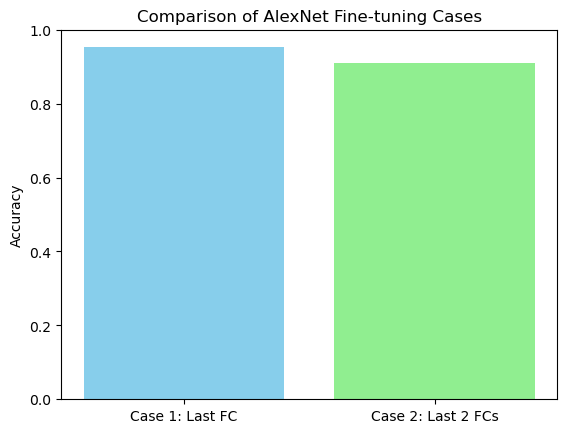

In [9]:
# 5. Comparison Plot
plt.bar(["Case 1: Last FC", "Case 2: Last 2 FCs"], [acc1, acc2], color=['skyblue', 'lightgreen'])
plt.ylabel("Accuracy")
plt.title("Comparison of AlexNet Fine-tuning Cases")
plt.ylim(0, 1)
plt.show()